In [1]:
import os
from rdkit import Chem
from rdkit import RDPaths
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

RDKit WARNING: [15:42:59] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
trainsdf = os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.train.sdf')
testsdf =  os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf')
prop_dict = {
    "(A) low": 0,
    "(B) medium": 1,
    "(C) high": 2
}


In [3]:
def ohencoder(cls, max_len):
    arr = np.zeros((max_len,), dtype=np.int64)
    arr[cls] = 1
    return arr

def fp2arr(fp):
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [4]:
nbits = 1024
ncls = 3

trainmols = [m for m in Chem.SDMolSupplier(trainsdf)]
testmols = [m for m in Chem.SDMolSupplier(testsdf)]

train_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nbits) for m in trainmols]
train_X = np.array([fp2arr(fp) for fp in train_fps], dtype=np.float32)

train_y = np.array([ohencoder(prop_dict[m.GetProp('SOL_classification')], ncls) for m in trainmols])
train_y = np.array([prop_dict[m.GetProp('SOL_classification')] for m in trainmols])
train_y = np.array(train_y, dtype=np.int64)

test_fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=nbits) for m in testmols]
test_X = np.array([fp2arr(fp) for fp in test_fps], dtype=np.float32)

test_y = np.array([ohencoder(prop_dict[m.GetProp('SOL_classification')], ncls) for m in testmols])
test_y = np.array([prop_dict[m.GetProp('SOL_classification')] for m in testmols])
test_y = np.array(test_y, dtype=np.int64)


In [5]:
import torch
if torch.cuda.is_available():
    print('use GPU')
    device='cuda'
else:
    print('use CPU')
    device='cpu'

use GPU


In [6]:
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
class SimpleMLP(nn.Module):
    def __init__(self, num_units=512, nonlin=F.relu):
        super(SimpleMLP, self).__init__()
        self.dense0 = nn.Linear(nbits, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, ncls)
    
    def forward(self, x, **kwargs):
        x = self.nonlin(self.dense0(x))
        x = self.dropout(x)
        x = F.relu(self.dense1(x))
        x = F.softmax(self.output(x), dim=-1)
        return x

In [8]:
net = NeuralNetClassifier(SimpleMLP,
                         max_epochs=100,
                         lr=0.1,
                         iterator_train__shuffle=True,
                         device=device
                         )

In [9]:
print(train_X.shape, train_y.shape)

(1025, 1024) (1025,)


In [10]:
net.fit(train_X, train_y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1241       0.3902        1.1102  0.1851
      2        1.0958       0.3902        1.0887  0.0205
      3        1.0753       0.3902        1.0770  0.0215
      4        1.0630       0.3902        1.0697  0.0190
      5        1.0550       0.3902        1.0635  0.0222
      6        1.0486       0.3902        1.0596  0.0210
      7        1.0418       0.3902        1.0570  0.0241
      8        1.0371       0.3902        1.0546  0.0249
      9        1.0326       0.4098        1.0521  0.0205
     10        1.0283       0.4098        1.0493  0.0217
     11        1.0208       0.4146        1.0465  0.0256
     12        1.0141       0.4683        1.0435  0.0252
     13        1.0077       0.5512        1.0394  0.0262
     14        0.9992       0.4488        1.0335  0.0261
     15        0.9895       0.5707        1.0286  0.0274
     16        0.9784       0.6

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleMLP(
    (dense0): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=512, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=3, bias=True)
  ),
)

In [11]:
pred = net.predict(test_X)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
confusion_matrix(test_y, pred)

array([[83, 18,  1],
       [35, 72,  8],
       [ 0, 11, 29]])

In [14]:
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       102
           1       0.71      0.63      0.67       115
           2       0.76      0.72      0.74        40

    accuracy                           0.72       257
   macro avg       0.73      0.72      0.72       257
weighted avg       0.72      0.72      0.71       257



In [15]:
from skorch import NeuralNetRegressor

In [16]:
class MLP_regressor(nn.Module):
    def __init__(self, num_units=512, nonlin=F.relu):
        super(MLP_regressor, self).__init__()
        self.dense0 = nn.Linear(nbits, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 1)
    
    def forward(self, x, **kwargs):
        x = self.nonlin(self.dense0(x))
        x = self.dropout(x)
        x = F.relu(self.dense1(x))
        x = self.output(x)
        return x

In [17]:
regressor = NeuralNetRegressor(MLP_regressor,
                              max_epochs=100,
                              iterator_train__shuffle=True,
                              device=device)

In [18]:
train_y_reg = np.array([float(m.GetProp('SOL')) for m in trainmols], dtype=np.float32).reshape(-1,1)
test_y_reg = np.array([float(m.GetProp('SOL')) for m in testmols], dtype=np.float32).reshape(-1,1)

In [19]:
regressor.fit(train_X, train_y_reg)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        8.3883       17.1863  0.0306
      2        6.5962       14.1763  0.0286
      3        5.0376       11.2894  0.0283
      4        3.8539        8.6574  0.0275
      5        3.2040        7.2481  0.0274
      6        3.0509        6.8971  0.0229
      7        2.9105        6.4633  0.0245
      8        2.8270        6.4574  0.0227
      9        2.7648        6.2469  0.0231
     10        2.6605        5.8732  0.0234
     11        2.5735        5.8100  0.0226
     12        2.4718        5.6538  0.0231
     13        2.3772        5.4258  0.0216
     14        2.2715        5.2761  0.0226
     15        2.1863        5.1872  0.0231
     16        2.1007        5.0222  0.0229
     17        2.0132        4.5049  0.0231
     18        1.9366        4.3733  0.0225
     19        1.8410        4.2831  0.0234
     20        1.7540        4.1578  0.0237
     21        1.7403        4.1

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MLP_regressor(
    (dense0): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=512, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=1, bias=True)
  ),
)

In [20]:
reg_y = regressor.predict(test_X)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'exp')

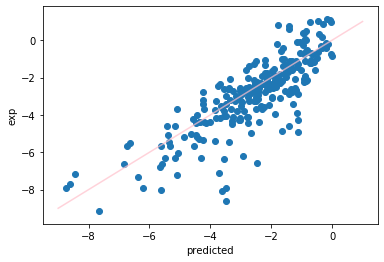

In [22]:
plt.plot(np.arange(-9,2), np.arange(-9,2), color='pink', alpha=0.7)
plt.scatter(reg_y, test_y_reg)
plt.xlabel('predicted')
plt.ylabel('exp')

In [23]:
from sklearn.metrics import r2_score
print(f"R2 score of testset was {r2_score(test_y_reg, reg_y):.2f}")

R2 score of testset was 0.65
